# HPC Execution Time Prediction using Random Forest
This notebook analyzes a synthetic dataset for predicting execution time of an HPC application on a CPU-GPU cluster using a random forest regression model.

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the Dataset
df = pd.read_csv('hpc_resource_prediction_dataset.csv')

In [3]:
# First five rows of data set
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
0,16795,207,22,2,445,4007,2.29,1.570850e+12,32.181662,13.506563,1332.733476
1,1860,901,31,16,158,7060,3.07,1.183560e+12,38.030452,31.306279,376.977304
2,77820,284,15,31,212,2696,3.48,7.674077e+11,25.483151,22.853398,6296.105486
3,55886,997,6,13,160,9980,2.62,2.264722e+11,14.891659,13.468920,43787.776310
4,7265,277,2,19,164,3421,2.32,1.745280e+12,37.637188,19.587622,1312.100958


In [4]:
# Number of rows and columns in dataset
df.shape

(10000, 11)

In [5]:
# Sixe of dataset (number of rows * number of columns)
df.size

110000

In [6]:
# Check for null value in dataset
df.isnull()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
9995,False,False,False,False,False,False,False,False,False,False,False
9996,False,False,False,False,False,False,False,False,False,False,False
9997,False,False,False,False,False,False,False,False,False,False,False
9998,False,False,False,False,False,False,False,False,False,False,False


In [7]:
# Sum of null values in each column(if any)
df.isnull().sum()

X1     0
X2     0
X3     0
X4     0
X5     0
X6     0
X7     0
X8     0
X9     0
X10    0
Y      0
dtype: int64

In [8]:
# Exploratory Data Analysis
df.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000
mean,50090.687500,530.837000,16.372300,16.446200,262.978400,5048.119300,2.255471,1.056307e+12,30.190795,19.958962,19582.748068
std,28744.346156,286.911671,9.192059,9.213034,144.132875,2866.452825,0.722340,5.448554e+11,11.622499,6.967346,39602.704873
min,1028.000000,32.000000,1.000000,1.000000,16.000000,100.000000,1.000000,1.002450e+11,10.001902,8.002763,4.315449
25%,25028.750000,284.000000,8.000000,8.000000,136.000000,2539.000000,1.640000,5.882194e+11,20.168918,13.919540,2568.303986
50%,49751.500000,535.000000,16.000000,16.000000,261.000000,5037.500000,2.250000,1.055982e+12,30.109566,19.885268,7505.775745
75%,75522.750000,783.000000,24.000000,24.000000,388.000000,7552.250000,2.890000,1.527215e+12,40.457861,26.105311,19344.063520
max,99991.000000,1024.000000,32.000000,32.000000,512.000000,10000.000000,3.500000,1.999737e+12,49.995802,31.997430,608288.971291


Column -- Name -- Description

X1 — Problem Size --  Represents the size of the computational problem (e.g., grid size in Game of Life). Larger sizes require more computational effort, impacting execution time.

X2 — Number of Threads --  Total number of threads launched to process the job. This affects parallelism — more threads can reduce computation time if well-utilized.

X3 — Number of Blocks --  In CUDA GPU programming, threads are organized into blocks. This value defines how many blocks are launched for computation.

X4 — Number of Grids --  A grid consists of blocks. The grid dimension controls the overall kernel launch configuration on GPU.

X5 — Number of CPU+GPU Cores --  Total processing cores available across CPUs and GPUs. More cores allow more parallel computation and can reduce execution time.

X6 — Number of Iterations --  The number of steps or time iterations the simulation must complete. More iterations increase the workload and execution time.

X7 — Max Clock Rate (GHz) --  The highest operating frequency of the CPU+GPU. A higher clock rate generally allows faster processing per core.

X8 — FLOPS (CPU+GPU) --  Floating Point Operations Per Second. This is a measure of the raw computational performance of the system.

X9 — Theoretical Bandwidth (CPU+GPU) --  Maximum achievable data transfer rate within the CPU and GPU memory subsystems (in GB/s). Affects how fast data can be fetched or stored.

X10 — PCI-e Bandwidth --  The communication bandwidth between CPU and GPU over the PCI-express bus. Higher values reduce data transfer delays between CPU and GPU.

In [9]:
# Information about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      10000 non-null  int64  
 1   X2      10000 non-null  int64  
 2   X3      10000 non-null  int64  
 3   X4      10000 non-null  int64  
 4   X5      10000 non-null  int64  
 5   X6      10000 non-null  int64  
 6   X7      10000 non-null  float64
 7   X8      10000 non-null  float64
 8   X9      10000 non-null  float64
 9   X10     10000 non-null  float64
 10  Y       10000 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 859.5 KB


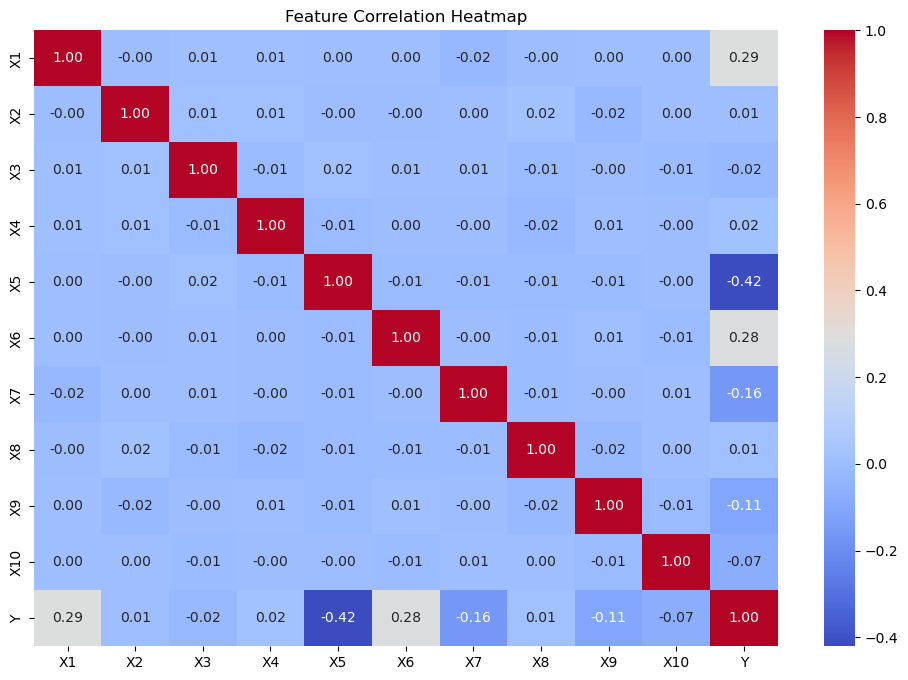

In [10]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [11]:
# Splitting data into Train-Test split 
X = df.drop(columns=['Y'])
y = df['Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
# Train Random forest Model

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [13]:
# Evaluate the Model
import math
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root mean square Error: {rmse:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Absolute Error: 4664.76
Root mean square Error: 15032.86
R^2 Score: 0.87


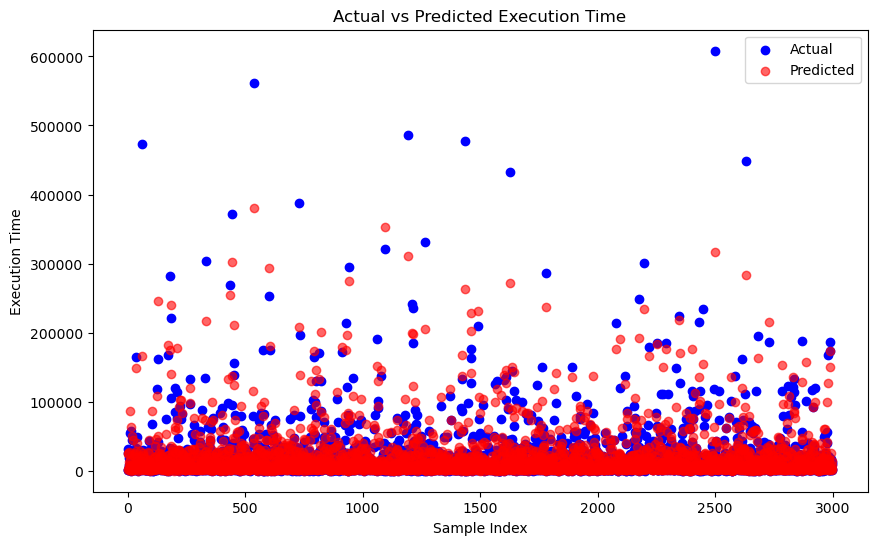

In [14]:
# Visualize Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')
plt.scatter(range(len(y_pred)), y_pred, color='red', alpha=0.6, label='Predicted')
plt.title('Actual vs Predicted Execution Time')
plt.xlabel('Sample Index')
plt.ylabel('Execution Time')
plt.legend()
plt.show()

In [22]:
# Predict Execution Time for New Input
# Define a new sample input as a dictionary
new_sample = pd.DataFrame([{
    'X1': 19721,
    'X2': 258,
    'X3': 16,
    'X4': 16,
    'X5': 256,
    'X6': 5000,
    'X7': 2.5,
    'X8': 1000245008771,
    'X9': 40.0,
    'X10': 16.0
}])

predicted_time = rf.predict(new_sample)
print(f"Predicted Execution Time for New Input: {predicted_time[0]:.2f}")

Predicted Execution Time for New Input: 2454.09
